# Posterior Prior Prediction for CKD using GLM

# Problem Statement

We are trying to understand the causal effect of 3 predictor variables on our outcome variable, followed by developing a predictive model that uses Generalized Linear Models with logistic and binomial regression to predict the presence or absence of Chronic Kidney Disease based on clinical and laboratory data.

### Reference
We have used and gone through the following paper for better understanding of the data.

Rashed-Al-Mahfuz M, Haque A, Azad A, Alyami SA, Quinn JMW, Moni MA. Clinically Applicable Machine Learning Approaches to Identify Attributes of Chronic Kidney Disease (CKD) for Use in Low-Cost Diagnostic Screening. IEEE J Transl Eng Health Med. 2021 Apr 15;9:4900511. doi: 10.1109/JTEHM.2021.3073629. PMID: 33948393; PMCID: PMC8075287.

### Dataset 
We have used the Chronic Kidney Disease dataset available in Kaggle. The following link has the same : https://www.kaggle.com/datasets/mansoordaku/ckdisease/data 

### Imports and standardization

In [1]:
# Set random seed and ensure plots are displayed in the notebook
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(5)
from scipy import stats

%matplotlib inline

%config Inline.figure_format = 'retina'
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# utility function for standardizing variables
def standardize(series):
    return (series - series.mean()) / series.std()

### Data

The Dataset has many pre-processing requirements. There are many NaN values which have to be dealt with and we need to be wary about types of data. There are about 13 numerical data and 11 non-numerical data. Among the numerical data column some are in string formate, they are to be converted, but while converting we came across few '?' in the dataset, which were manually changed to NaN. After converting such String columns to int or float the non-numerical dataset have undergone data transformation. After data transform, the dataset is further cleaned by doping the NaN values etc. The cleaning process is provided in the reference paper, the same is followed.

In [4]:
# Read the CSV file
df = pd.read_csv("processed_kidney_data.csv", sep=",", header=0, index_col=0)

# View the first 5 rows
df.head()

,id,age,bp,sg,al,su,bgr,bu,sc,sod,...,bi_pcc,bi_pc,bi_ba,bi_rbc,bi_htn,bi_dm,bi_cad,bi_appet,bi_pe,bi_ane
0,0,48.0,80.0,1.020,1.0,0.0,121.000000,36.0,1.2,137.54886,...,0,1,0,0,1,1,0,1,0,0
1,1,7.0,50.0,1.020,4.0,0.0,148.043103,18.0,0.8,137.54886,...,0,1,0,0,0,0,0,1,0,0
2,2,62.0,80.0,1.010,2.0,3.0,423.000000,53.0,1.8,137.54886,...,0,1,0,1,0,1,0,0,0,1
3,3,48.0,70.0,1.005,4.0,0.0,117.000000,56.0,3.8,111.00000,...,1,0,0,1,1,0,0,0,1,1
4,4,51.0,80.0,1.010,2.0,0.0,106.000000,26.0,1.4,137.54886,...,0,1,0,1,0,0,0,1,0,0


In [5]:
df.mean()

id                    200.820972
age                    51.483376
bp                     76.490765
sg                      9.510623
al                      9.302053
su                      9.397891
bgr                   148.043103
bu                     57.040860
sc                      3.056551
sod                   137.548860
pot                     4.632353
hemo                   12.576246
pcv                    39.018576
wc                   8405.517241
rc                      4.712782
bi_classification       0.613811
bi_pcc                  0.117647
bi_pc                   0.654731
bi_ba                   0.066496
bi_rbc                  0.511509
bi_htn                  0.363171
bi_dm                   0.335038
bi_cad                  0.097187
bi_appet                0.790281
bi_pe                   0.191816
bi_ane                  0.148338
dtype: float64

In [6]:
df.describe()

,id,age,bp,sg,al,su,bgr,bu,sc,sod,...,bi_pcc,bi_pc,bi_ba,bi_rbc,bi_htn,bi_dm,bi_cad,bi_appet,bi_pe,bi_ane
count,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.00000,391.000000,391.000000,...,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000
mean,200.820972,51.483376,76.490765,9.510623,9.302053,9.397891,148.043103,57.04086,3.056551,137.548860,...,0.117647,0.654731,0.066496,0.511509,0.363171,0.335038,0.097187,0.790281,0.191816,0.148338
std,116.142524,17.169714,13.514732,23.881618,23.682054,24.552156,75.253560,49.36639,5.665844,9.295818,...,0.322603,0.476065,0.249467,0.500508,0.481530,0.472609,0.296591,0.407629,0.394233,0.355890
min,0.000000,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.50000,0.400000,4.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,99.500000,42.000000,70.000000,1.015000,0.000000,0.000000,101.000000,27.00000,0.900000,135.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,202.000000,55.000000,80.000000,1.020000,0.000000,0.000000,125.000000,44.00000,1.400000,137.548860,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,301.500000,64.500000,80.000000,1.025000,3.000000,1.000000,150.000000,60.00000,3.056551,141.000000,...,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,399.000000,90.000000,180.000000,76.490765,76.490765,76.490765,490.000000,391.00000,76.000000,163.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Upon going through the data description and mean values we were able to understand how to data is ruffly distributed.

### Predictor variables and target variable

For this analysis we have considered 3 predictor variables for our outcome or target variable.

The following is the DAG diagram for the same.

![](dag.png)

In the above DAG diagram:
- al : "Albumin"
- pcv : "Packed Cell Volume"
- bu : "Blood Urea"
- ckd : "Chronic Kidney Disease" => our target variable

### Prior choosing justification

In [7]:
urea_seq = np.linspace(-2, 2, 391)
pcv_seq = np.linspace(-2, 2, 391)
al_seq = np.linspace(-2, 2, 391)

In [8]:
# first-order linear model
n = 20

beta_urea = stats.norm.rvs(0, 0.3, size = n)
beta_pcv = stats.norm.rvs(0, 0.3, size = n)
beta_al = stats.norm.rvs(0, 0.3, size = n)

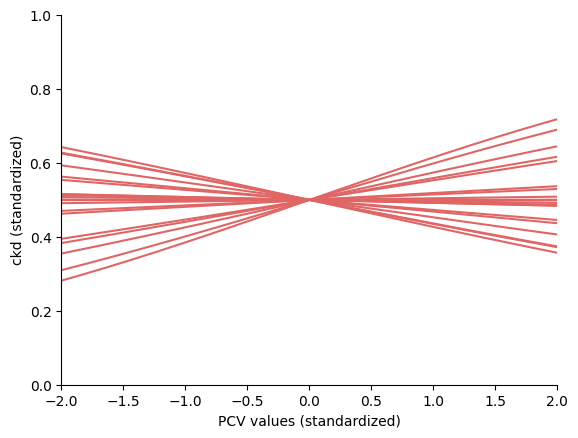

In [9]:
# Logistic regression model
for i in range(n):
    # logits =  beta_pcv * pcv_seq
    logits = 1 / (1 + np.exp(-(beta_pcv[i] * pcv_seq )))
    plt.plot(pcv_seq, logits, color="#e06666")

plt.xlim((-2, 2))
plt.ylim((0, 1))
plt.xlabel("PCV values (standardized)")
plt.ylabel("ckd (standardized)")
sns.despine();

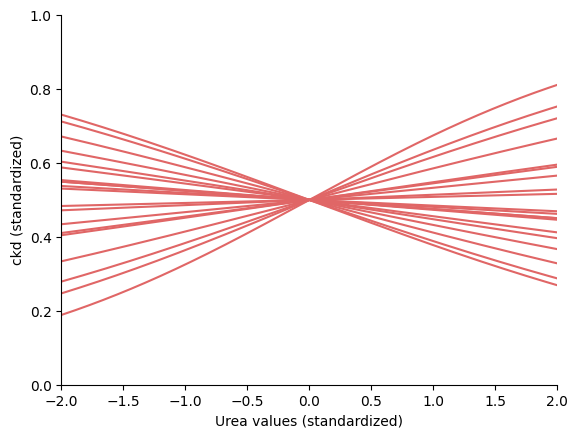

In [10]:
# Logistic regression model
for i in range(n):
    # logits =  beta_urea * urea_seq 
    logits = 1 / (1 + np.exp(-(beta_urea[i] * urea_seq )))
    plt.plot(urea_seq, logits, color="#e06666")

plt.xlim((-2, 2))
plt.ylim((0, 1))
plt.xlabel("Urea values (standardized)")
plt.ylabel("ckd (standardized)")
sns.despine();

In [11]:
beta_urea = stats.norm.rvs(0, 0.25, size = n)

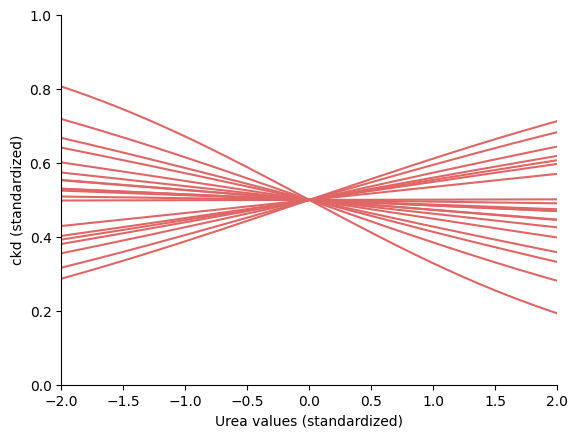

In [12]:
# Logistic regression model
for i in range(n):
    # logits =  beta_urea * urea_seq 
    logits = 1 / (1 + np.exp(-(beta_urea[i] * urea_seq )))
    plt.plot(urea_seq, logits, color="#e06666")

plt.xlim((-2, 2))
plt.ylim((0, 1))
plt.xlabel("Urea values (standardized)")
plt.ylabel("ckd (standardized)")
sns.despine();

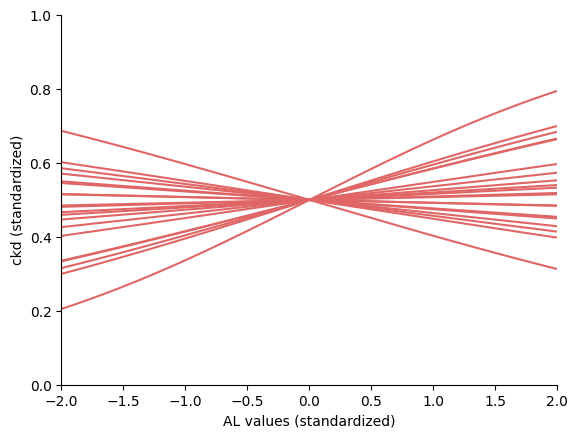

In [13]:
# Logistic regression model
for i in range(n):
    logits = 1 / (1 + np.exp(-(beta_al[i] * al_seq )))
    plt.plot(al_seq, logits, color="#e06666")

plt.xlim((-2, 2))
plt.ylim((0, 1))
plt.xlabel("AL values (standardized)")
plt.ylabel("ckd (standardized)")
sns.despine();

The predictor variables chosen all have continuous values and so to standardize the priors we have taken values between -2 to 2.

The above graphs shows how the priors are associated with the outcome variable. We can clearly see that given any value the probability of ckd is well distributed between 20% and 70% for all predictor variables, justifying our choice of mean and sigma value for the prior distributions.

In [14]:
# Extracting values from data
pcv = standardize(df['pcv'].values) 
ckd = df['bi_classification'].values 
urea = standardize(df['bu'].values)  
al = standardize(df['al'].values)

### PCV, Urea, Albumin model

In [15]:
# Model structure
with pm.Model() as model:
    # Priors for the logistic regression coefficients
    beta_urea = pm.Normal('beta_urea', mu=0, sigma=0.25)
    beta_PCV = pm.Normal('beta_PCV', mu=0, sigma=0.3)
    beta_al = pm.Normal('beta_al', mu=0, sigma=0.3)

    #    # Define likelihood
    p = pm.invlogit(beta_urea * urea + beta_PCV * pcv + beta_al * al)
    y_observed = pm.Bernoulli('ckd', p=p, observed=ckd)

    # Draw samples from the prior
    best_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_urea, beta_PCV, beta_al]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


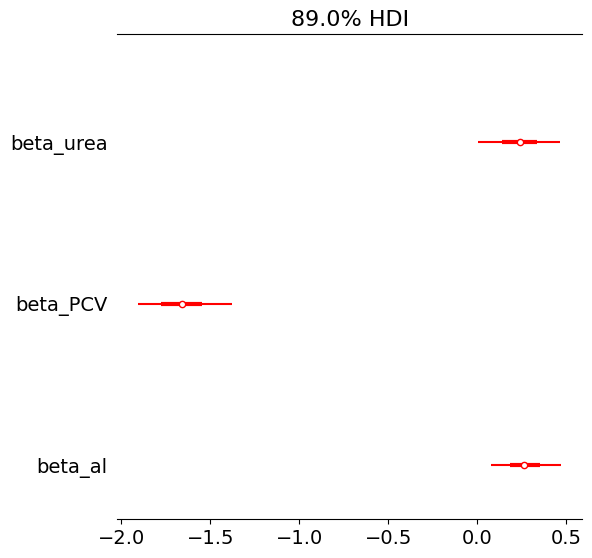

In [16]:
_ = az.plot_forest(best_trace, colors='r', combined=True, hdi_prob= 0.89)

array([[<Axes: title={'center': 'beta_urea'}>,
        <Axes: title={'center': 'beta_urea'}>],
       [<Axes: title={'center': 'beta_PCV'}>,
        <Axes: title={'center': 'beta_PCV'}>],
       [<Axes: title={'center': 'beta_al'}>,
        <Axes: title={'center': 'beta_al'}>]], dtype=object)

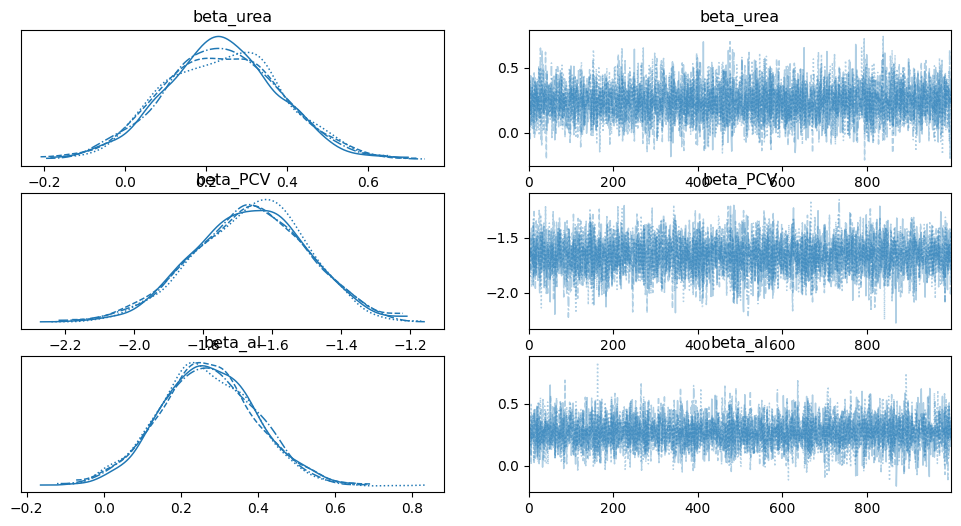

In [17]:
az.plot_trace(best_trace)

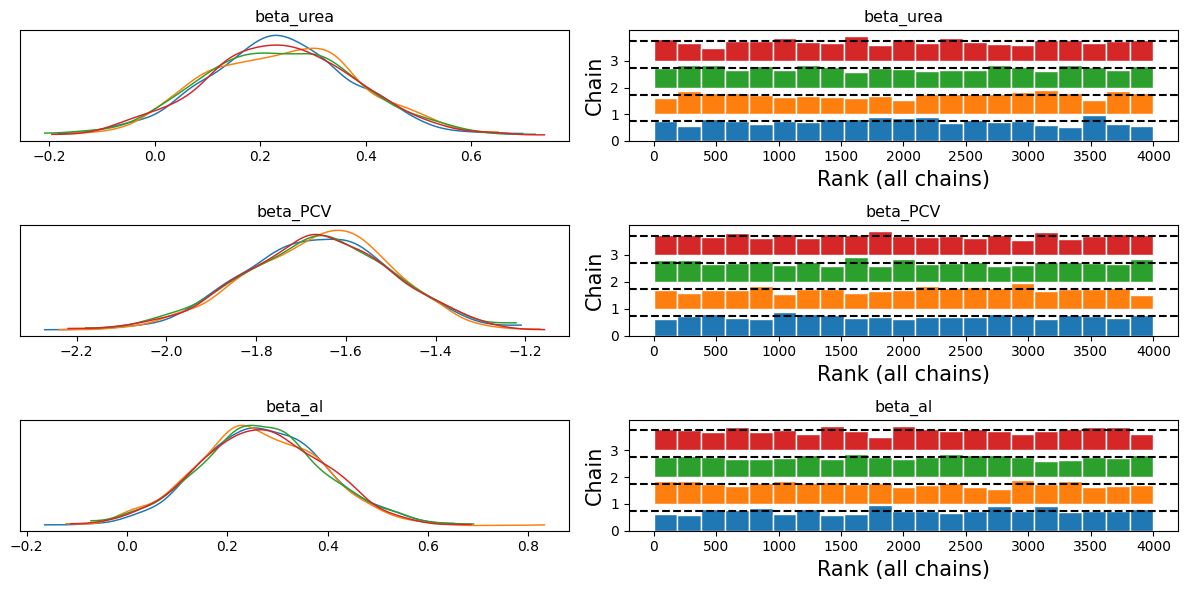

In [18]:
_ = az.plot_trace(best_trace, kind="rank_bars", var_names="~p", compact=False)
plt.tight_layout()

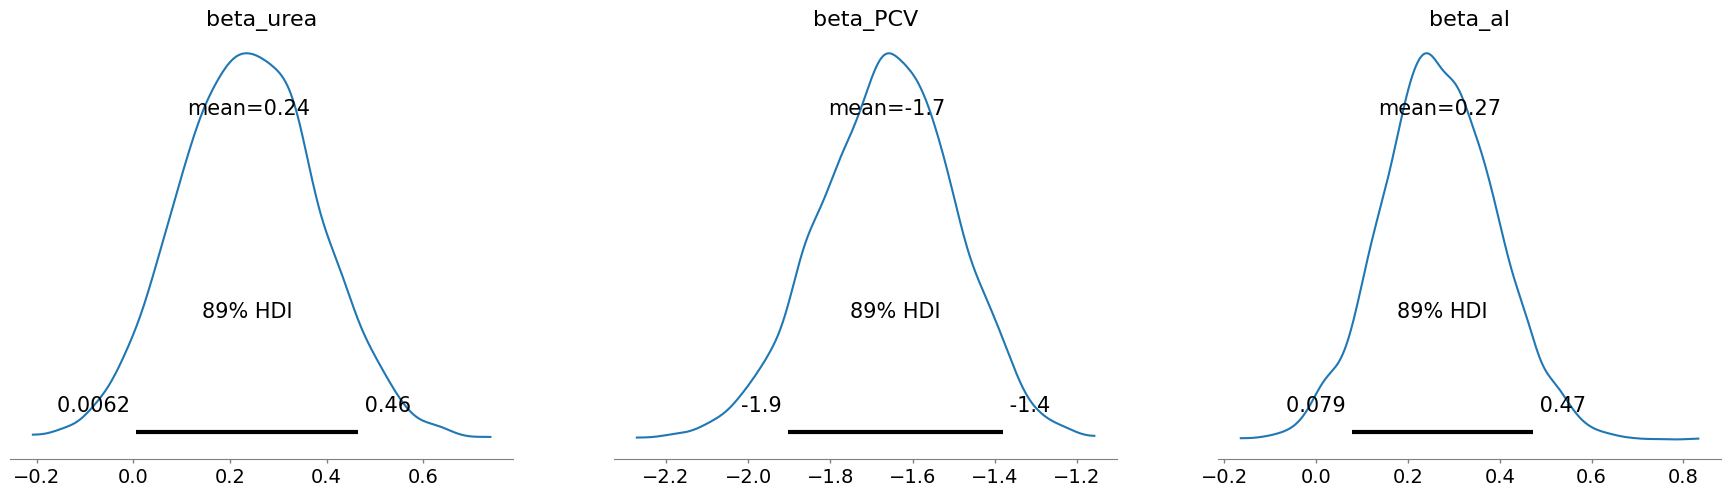

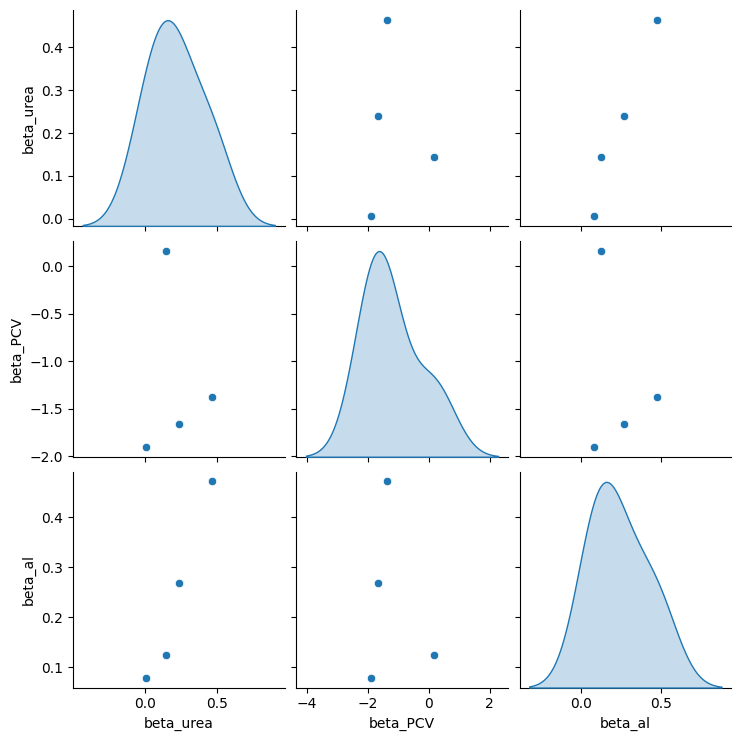

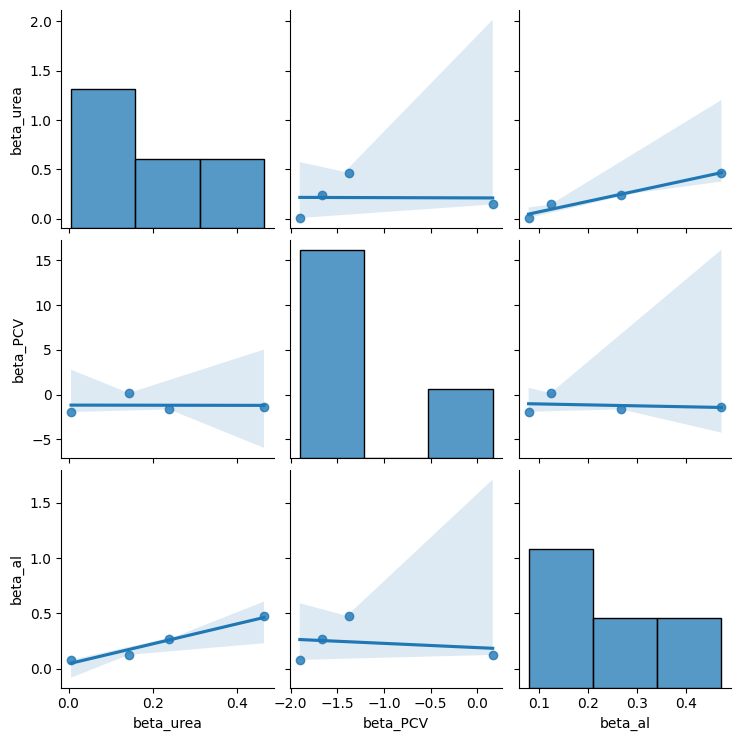

In [19]:
# Assuming 'best_trace' is your MCMC trace from the best model
with model:
    # Posterior distribution plots for beta_urea, beta_PCV, and beta_al
    az.plot_posterior(best_trace, var_names=['beta_urea', 'beta_PCV', 'beta_al'])
    plt.show()

    # Joint plot of beta_urea, beta_PCV, and beta_al from posterior
    df_trace = az.summary(best_trace, kind='stats')
    # Transpose df_trace to make 'beta_urea', 'beta_PCV', and 'beta_al' columns
    df_trace = df_trace.transpose()
    
    sns.pairplot(df_trace[['beta_urea', 'beta_PCV', 'beta_al']], kind='scatter', diag_kind='kde')
    plt.show()

    # Correlation plot
    sns.pairplot(df_trace[['beta_urea', 'beta_PCV', 'beta_al']], kind='reg')
    plt.show()

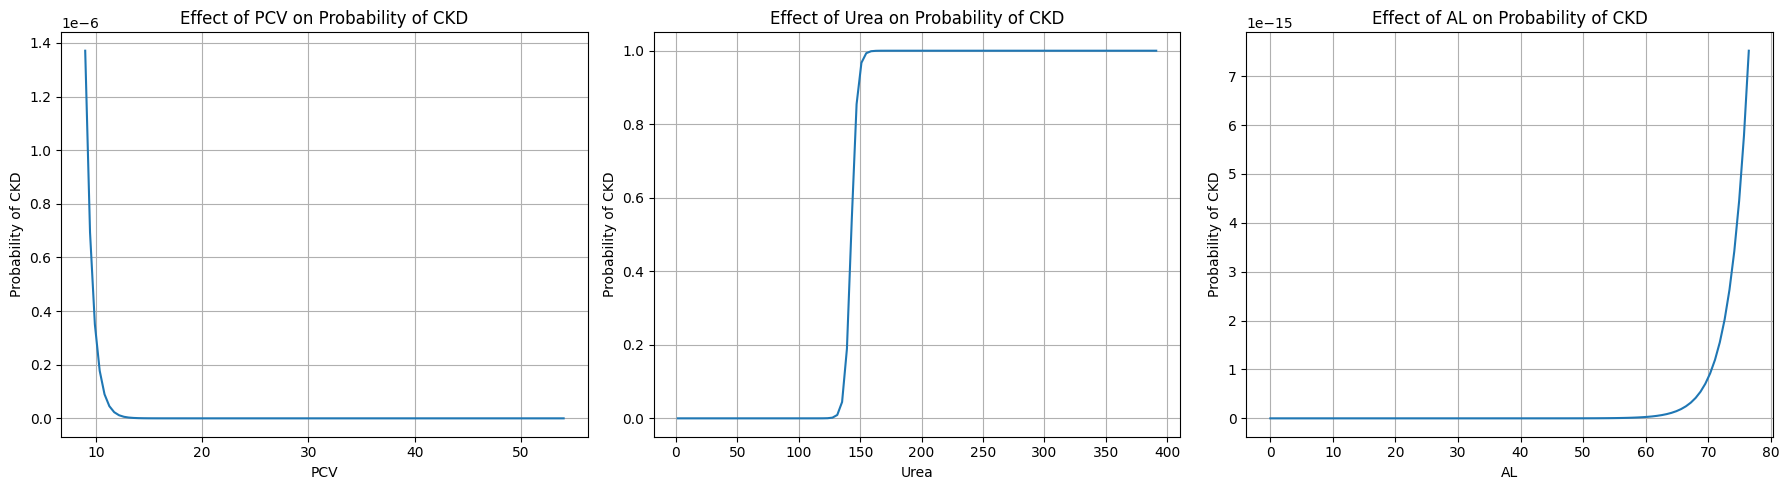

In [20]:

# Assuming the coefficients you've provided
beta_urea_mean = 0.41  # Extract mean value of beta_urea from best_trace
beta_PCV_mean = -1.5   # Extract mean value of beta_PCV from best_trace
beta_al_mean = 0.34   # Extract mean value of beta_al from best_trace

urea_mean = np.mean(df['bu'])  # or some representative value
pcv_mean = np.mean(df['pcv'])  # or some representative value
al_mean = np.mean(df['al'])    # or some representative value

# Creating a range of values for PCV, Urea, and AL
pcv_values = np.linspace(np.min(df['pcv']), np.max(df['pcv']), 100)
urea_values = np.linspace(np.min(df['bu']), np.max(df['bu']), 100)
al_values = np.linspace(np.min(df['al']), np.max(df['al']), 100)

# Calculating the predicted probabilities
p_pcv = 1 / (1 + np.exp(-(beta_PCV_mean * pcv_values )))
p_urea = 1 / (1 + np.exp(-(beta_PCV_mean * pcv_mean + beta_urea_mean * urea_values)))
p_al =  1 / (1 + np.exp(-(beta_PCV_mean * pcv_mean + beta_al_mean * al_values)))

# Plotting
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(pcv_values, p_pcv, label='Effect of PCV')
plt.title('Effect of PCV on Probability of CKD')
plt.xlabel('PCV')
plt.ylabel('Probability of CKD')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(urea_values, p_urea, label='Effect of Urea')
plt.title('Effect of Urea on Probability of CKD')
plt.xlabel('Urea')
plt.ylabel('Probability of CKD')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(al_values, p_al, label='Effect of AL')
plt.title('Effect of AL on Probability of CKD')
plt.xlabel('AL')
plt.ylabel('Probability of CKD')
plt.grid(True)

plt.tight_layout()
plt.show()

From the posterior distribution graphs we are able to make the following comments:
- Its clearly seen that the mean of posterior distribution of "urea" is +0.42, indicating a positive correlation with the target variable, implying that with increase in blood urea value the probability of a patient having CKD increases.
- Its clearly seen that the mean of posterior distribution of "pcv is -1.5, indicating a negative correlation with the target variable, implying that with increase in pcv value the probability of a patient having CKD decreases.
- Its clearly seen that the mean of posterior distribution of "al" is +0.34, indicating a positive correlation with the target variable, implying that with increase in blood urea value the probability of a patient having CKD increases.


From the probability graph the following is clear:
- From the 1st graph its clear that the probability of ckd is high when the pcv value decreases, more specifically when the pcv value drops from 12.
- From the 2nd graph its clear that the probability of ckd increase as the urea value increases, more specifically when the urea value increases more than 120.
- From the 3rd graph its clear that the probability of ckd increases as the al value increases, more specifically when the al value increases more than 65.

### Posterior Predictive Checks

### PCV


In [21]:
# creating a sequence for pcv 
pcv_seq = np.linspace(-4, 4)

idata_thinned = az.extract_dataset(best_trace)
mu_pred_obs = np.zeros((len(pcv), idata_thinned.sizes["sample"]))

num_samples=391

mu_pred = np.zeros((len(pcv_seq), idata_thinned.sizes["sample"]))
beta_pcv_samples = idata_thinned.beta_PCV.values

for i, a in enumerate(beta_pcv_samples):
    # mu_pred[i] =  beta_pcv_samples * (a)
    mu_pred[:,i] = 1 / (1 + np.exp(-(a * pcv_seq )))

<Axes: ylabel='Density'>

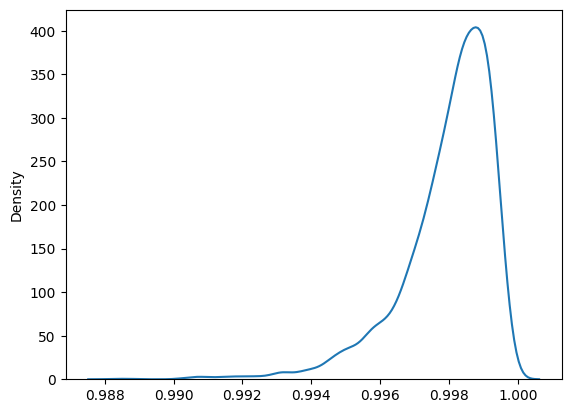

In [22]:
sns.kdeplot(mu_pred[1])

In [23]:
mu_mean = mu_pred.mean(1)
# mu_hdi = az.hdi(mu_pred.T)

In [24]:
preds = mu_pred.T
# preds= standardize(preds)
preds.max()

0.99988715911625

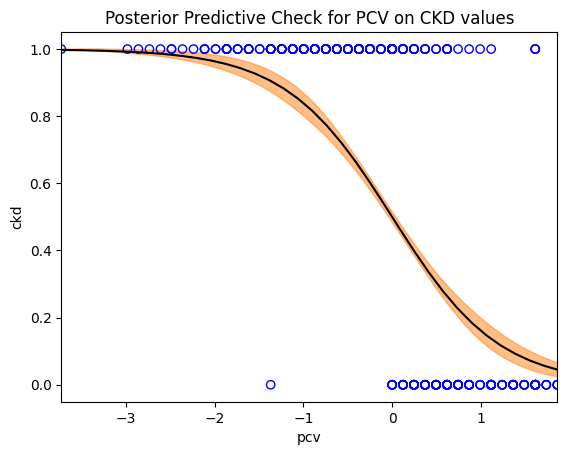

In [25]:
# plot a shaded region for 89% PI
az.plot_hdi(pcv_seq, mu_pred.T)

# plot raw data
plt.scatter(pcv, ckd, facecolors='none', edgecolors='b')

# plot the MAP line, aka the mean mu for each weight
plt.plot(pcv_seq, mu_mean, "k")

plt.title("Posterior Predictive Check for PCV on CKD values")
plt.xlabel("pcv")
plt.ylabel("ckd")
plt.xlim(pcv.min(), pcv.max());

From the above graph we can see that as the pcv value decreases the ckd probability increases, this shows the same behavior as observed in the posterior. Due to the fact that there are few outliers seen in the plot there are some uncertainty, and its observed that this uncertainty is big at the mid. Similar graph can be plotted for urea and Al values but because they both have some effect through pcv combination of the values will need to be taken for plotting. 

From the above analysis and checks we can come to a basic understanding that:
- Urea and Al value have negative correlation with CKD
- PCV has positive correlation with CKD
- There are few uncertainty because of outliers.

The observed analysis and causal effect align with the one observed in the reference paper and aligns with the biological aspects of the values.

### Screen cast

The following link has the screen cast : https://drive.google.com/file/d/1ie7k1wm_qx-Tm65wNAdQTkB6UhzePmee/view?usp=sharing